In [ ]:
# This is a brief attempt to model a allocation framework based on cross-asset correlations.
# It is known that correlation between different classes of financial assets can vary over time, not only in intensity but also in direction.
# Spotting solid cross-asset correlations is foundational to a series of portfolio management strategies such as in Modern Portfolio Theory, 
# because they allow for proper risk management via careful asset picking in accordance to the desired risk profile 
# (less correlated assets: more hedged portfolio | more correlated assets: greater implied risk, aiming for greater returns).
# The problem with Modern Portfolio Theory is that given it's mean-variance returns nature, portfolios often
# oscillate around it's benchmarks in mean-regressions (often the SPX or the 60/40 portfolio), killing in the
# long-term potential benefits from risk taking strategies (see SPIVA* scoreboard for more on this).
# A more suitable portfolio management strategy, in my opinion, is Barbell's. While not so much applied for assets other than bonds, Barbell's
# logic seems superior for the fact that you keep most of your portfolio as risk-free as possible, like in allocation into the US 03-month bills, 
# while aggresively pursuing riskier trades with greater risk:reward assymetries. Obviously, this trade-off
# doesn't come without it's own pitfalls: if the risk-taking leg of the portfolio doesn't perform as expected, the overall portfolio
# will underperform a more balanced MPT portfolio. So, it's not just abount taking more risk, the quality of that risk matters the most.
# And for this reason, I aim through this cross-correlation study to spot solid momentary correlation between
# different assets, and of varied categories (futures, commodities, treasuries, variance swaps, macro data, etc)
# in order to find high-probability short-term trades (day and swing trades). By finding several risk-taking and preferably uncorrelated strategies,
# I can avoid directional exposure, diluting the overall risk of the portfolio without increasing the necessity of hedge via derivatives such as options and futures.
# Also, by taking risk in smaller amounts and increased frequencies instead of few larger trades, I ensure the portfolio's risk-taking leg
# will not blow up before yielding returns, as long as the strategies employed are of high-probability in respect of their risk:reward profiles. 
# It's sheer casino math at play here, which makes the house always win.
# In order to find these golden strategies, I will employ a number of steps that form a solid framework for financial data analysis:
# 1 - clean and prepare the data from the different sources
# 2 - analyse the data for normality, or the lack thereof, via a number of methods
# 3 - analyse the data for other, non-normal distributions, to either confirm normality or anormality assessed from previous step
# 4 - analyse the data in the light of Extreme Value Theory in order to spot sensible dynamics that can offer potential risks and opportunities
# 5 - analyse the correlations, both spot and legged about several assets from varied classes in order to try to extract meaningful dynamics
# 6 - analyse tail residuals to try to unveil more relevant data
# 7 - employ different machine learning techniques such as XGBoost, Regression Forest and LSTM in order to try to CATEGORIZE the next trading day
# of a given asset as either bullish, bearish or neutral. If categorization is succesful, use the resultant data to try to predict by how much
# the asset is likely to move in respect of the direction given by it's categorical label (i.e. by how much Gold Futures are likely to fall if given
# a Bearish stamp for the day)
# 8 - Regardless of success rate, apply techniques of Conformal Prediction to add robustness to the results if positive, or to improve them if negative
# 9 - construct new features in order to add more data for analysis, i.e. bond spreads, futures curves and their variations over time, moving averages
# and other indicators of technical analysis, number of assets following a given pattern at a given time, etc
# 10 - reapply the entire analysis framework to entire data again, now aggregating the new features
# 11- report the results in detail, expanding on the findings, successes and downfalls
# This challenge is enourmous and actually very computational-demanding. Given my current constrains in terms of data abundance and reliability,
# this work should be approached merely as a study on general data science - albeit a more complex one than simply dabbling with synthetic
# datasets from Kaggle and Hugging Face but still just a study. Also, the dataset can grow in no time, potentially limitting my progress as intended
# for this work due to compute restraints, either from my own device or from Google Colab's free-tier instances. The original dataset alone, which consists
# of a series of historical quotes for several commodity futures contracts**, the SPY historical quotes*** and the US 10-year tresury yields****,
# comprises of 10 columns by 6000 rows after data cleaning and processing. This dataset can EASILY grow by more 30-50 columns without much effort,
# just by adding spreads and technical indicators such as moving averages, so the dimensionality curse is real here. In order to tackle it, 
# I plan to examine the dataset in smaller batches if it becomes impossible to be analysed in it's entirety, and probably use emsemble methods 
# in order to form a big picture from the smaller data. I plan to avoid random subsampling because financial data is too ciclical
# to retain coherence if stripped off of it's continuity. Also, correlations are often short-term in a noisy and inherently chaotic environment, 
# so missing data might cause lack sufficient information to place a trade in the best scenario, or be extremely misleading in the worst, inducing
# risk-taking in potentially adverse conditions.

In [ ]:
# * https://www.spglobal.com/spdji/en/research-insights/spiva/#us
# ** https://www.kaggle.com/datasets/albertobircoci/historical-prices-of-major-natural-resource
# *** fetched from Yahoo Finance via YFinance library
# **** https://fred.stlouisfed.org/series/DGS10 - Board of Governors of the Federal Reserve System (US),
# Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis [DGS10],
# retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DGS10, April 9, 2025.

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import yfinance as yf
from scipy.stats import normaltest, kurtosis, skew, kstest, t, skewnorm, cauchy, logistic, genpareto, genextreme, rankdata
from statsmodels.sandbox.stats.runs import Runs

In [2]:
from pathlib import Path

In [3]:
print(Path.cwd())

C:\Users\USER\Desktop\Python Projects\ml-studies\src\ml_studies


In [4]:
dataset_dir = Path.cwd() 

In [5]:
dataset_futures_csv_path = dataset_dir / "datasets" / "Futures_Resources_Data.csv"
dataset_us10y_csv_path = dataset_dir /"datasets" / "DGS10.csv"

In [6]:
df_futures = pd.read_csv(dataset_futures_csv_path)
df_us10y = pd.read_csv(dataset_us10y_csv_path)

In [7]:
df_futures.head()

Date  CL=F_closing_price  BZ=F_closing_price  GC=F_closing_price  \
0  29/10/97                 NaN                 NaN                 NaN   
1  30/10/97                 NaN                 NaN                 NaN   
2  31/10/97                 NaN                 NaN                 NaN   
3  03/11/97                 NaN                 NaN                 NaN   
4  04/11/97                 NaN                 NaN                 NaN   

   SI=F_closing_price  NG=F_closing_price  ZC=F_closing_price  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   ZW=F_closing_price  ZS=F_closing_price  HG=F_closing_price  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   PL=F_closing_price  PA=F_closing_price  
0          402.700012                 NaN  
1          405.299988                 NaN  
2          404.200012                 NaN  
3          406.500000                 NaN  
4          405.700012                 NaN

In [8]:
df_futures.tail()

Date  CL=F_closing_price  BZ=F_closing_price  GC=F_closing_price  \
6900  26/03/25           69.650002           73.790001         3020.899902   
6901  27/03/25           69.919998           74.029999         3060.199951   
6902  28/03/25           69.360001           73.629997         3086.500000   
6903  31/03/25           71.480003           74.739998         3122.800049   
6904  01/04/25           71.489998           74.750000         3163.800049   

      SI=F_closing_price  NG=F_closing_price  ZC=F_closing_price  \
6900           34.033001               3.861              451.25   
6901           34.896999               3.950              450.00   
6902           34.644001               4.065              453.25   
6903           34.457001               4.119              457.25   
6904           34.759998               4.069              467.75   

      ZW=F_closing_price  ZS=F_closing_price  HG=F_closing_price  \
6900              535.25             1001.00              5.2160   
6901              532.00             1016.75              5.0975   
6902              528.25             1023.00              5.1125   
6903              537.00             1014.75              5.0200   
6904              552.25             1032.00              5.0560   

      PL=F_closing_price  PA=F_closing_price  
6900          967.900024          962.500000  
6901          983.200012          973.799988  
6902          977.700012          974.299988  
6903         1009.700012          991.200012  
6904          994.000000          999.000000

In [9]:
df_futures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6905 entries, 0 to 6904
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                6905 non-null   object 
 1   CL=F_closing_price  6177 non-null   float64
 2   BZ=F_closing_price  4395 non-null   float64
 3   GC=F_closing_price  6168 non-null   float64
 4   SI=F_closing_price  6170 non-null   float64
 5   NG=F_closing_price  6174 non-null   float64
 6   ZC=F_closing_price  6181 non-null   float64
 7   ZW=F_closing_price  6193 non-null   float64
 8   ZS=F_closing_price  6173 non-null   float64
 9   HG=F_closing_price  6173 non-null   float64
 10  PL=F_closing_price  6196 non-null   float64
 11  PA=F_closing_price  6208 non-null   float64
dtypes: float64(11), object(1)
memory usage: 647.5+ KB


In [10]:
df_futures.shape

(6905, 12)

In [11]:
df_futures.isna().any(axis=0).sum()

np.int64(11)

In [12]:
df_futures.isna().any(axis=1).sum()

np.int64(2981)

In [13]:
df_futures.columns

Index(['Date', 'CL=F_closing_price', 'BZ=F_closing_price',
       'GC=F_closing_price', 'SI=F_closing_price', 'NG=F_closing_price',
       'ZC=F_closing_price', 'ZW=F_closing_price', 'ZS=F_closing_price',
       'HG=F_closing_price', 'PL=F_closing_price', 'PA=F_closing_price'],
      dtype='object')

In [14]:
df_futures['Date'] = pd.to_datetime(df_futures['Date'], format='%d/%m/%y')

In [15]:
df_futures.set_index('Date', inplace=True)

In [16]:
df_futures.index

DatetimeIndex(['1997-10-29', '1997-10-30', '1997-10-31', '1997-11-03',
               '1997-11-04', '1997-11-05', '1997-11-06', '1997-11-07',
               '1997-11-10', '1997-11-11',
               ...
               '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24',
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-03-31', '2025-04-01'],
              dtype='datetime64[ns]', name='Date', length=6905, freq=None)

In [17]:
df_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6905 entries, 1997-10-29 to 2025-04-01
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CL=F_closing_price  6177 non-null   float64
 1   BZ=F_closing_price  4395 non-null   float64
 2   GC=F_closing_price  6168 non-null   float64
 3   SI=F_closing_price  6170 non-null   float64
 4   NG=F_closing_price  6174 non-null   float64
 5   ZC=F_closing_price  6181 non-null   float64
 6   ZW=F_closing_price  6193 non-null   float64
 7   ZS=F_closing_price  6173 non-null   float64
 8   HG=F_closing_price  6173 non-null   float64
 9   PL=F_closing_price  6196 non-null   float64
 10  PA=F_closing_price  6208 non-null   float64
dtypes: float64(11)
memory usage: 647.3 KB


In [18]:
df_futures.index

DatetimeIndex(['1997-10-29', '1997-10-30', '1997-10-31', '1997-11-03',
               '1997-11-04', '1997-11-05', '1997-11-06', '1997-11-07',
               '1997-11-10', '1997-11-11',
               ...
               '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24',
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-03-31', '2025-04-01'],
              dtype='datetime64[ns]', name='Date', length=6905, freq=None)

In [19]:
df_futures.isnull().sum()

CL=F_closing_price     728
BZ=F_closing_price    2510
GC=F_closing_price     737
SI=F_closing_price     735
NG=F_closing_price     731
ZC=F_closing_price     724
ZW=F_closing_price     712
ZS=F_closing_price     732
HG=F_closing_price     732
PL=F_closing_price     709
PA=F_closing_price     697
dtype: int64

In [20]:
def nan_distribution(data):
    plt.figure(figsize=(15, 8))
    sns.heatmap(data.isnull(), cbar=True)
    plt.title("NaN Distribution Over Time")
    plt.show()

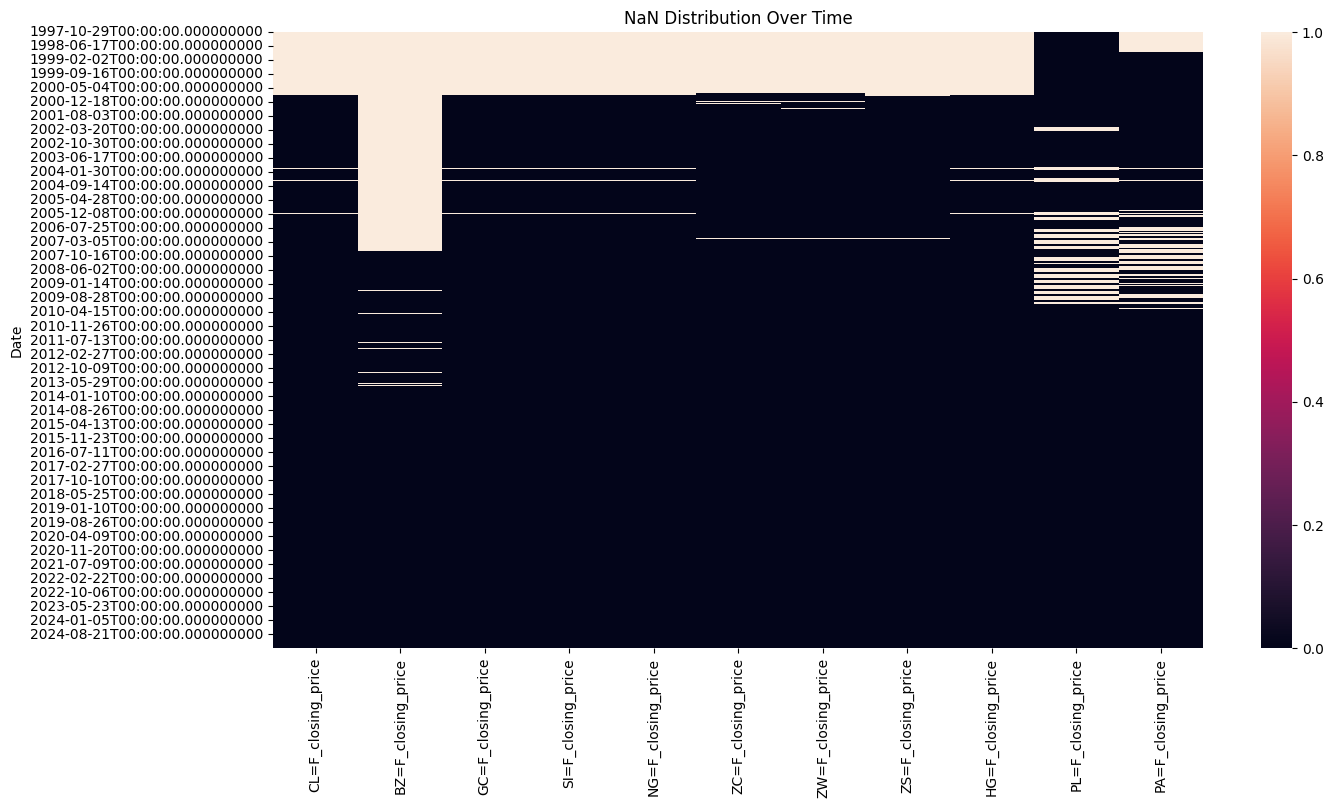

In [21]:
nan_distribution(df_futures)

In [22]:
df_futures.drop(columns=['BZ=F_closing_price', 'PL=F_closing_price', 'PA=F_closing_price'], inplace=True)

In [23]:
df_futures.head()

CL=F_closing_price  GC=F_closing_price  SI=F_closing_price  \
Date                                                                     
1997-10-29                 NaN                 NaN                 NaN   
1997-10-30                 NaN                 NaN                 NaN   
1997-10-31                 NaN                 NaN                 NaN   
1997-11-03                 NaN                 NaN                 NaN   
1997-11-04                 NaN                 NaN                 NaN   

            NG=F_closing_price  ZC=F_closing_price  ZW=F_closing_price  \
Date                                                                     
1997-10-29                 NaN                 NaN                 NaN   
1997-10-30                 NaN                 NaN                 NaN   
1997-10-31                 NaN                 NaN                 NaN   
1997-11-03                 NaN                 NaN                 NaN   
1997-11-04                 NaN                 NaN                 NaN   

            ZS=F_closing_price  HG=F_closing_price  
Date                                                
1997-10-29                 NaN                 NaN  
1997-10-30                 NaN                 NaN  
1997-10-31                 NaN                 NaN  
1997-11-03                 NaN                 NaN  
1997-11-04                 NaN                 NaN

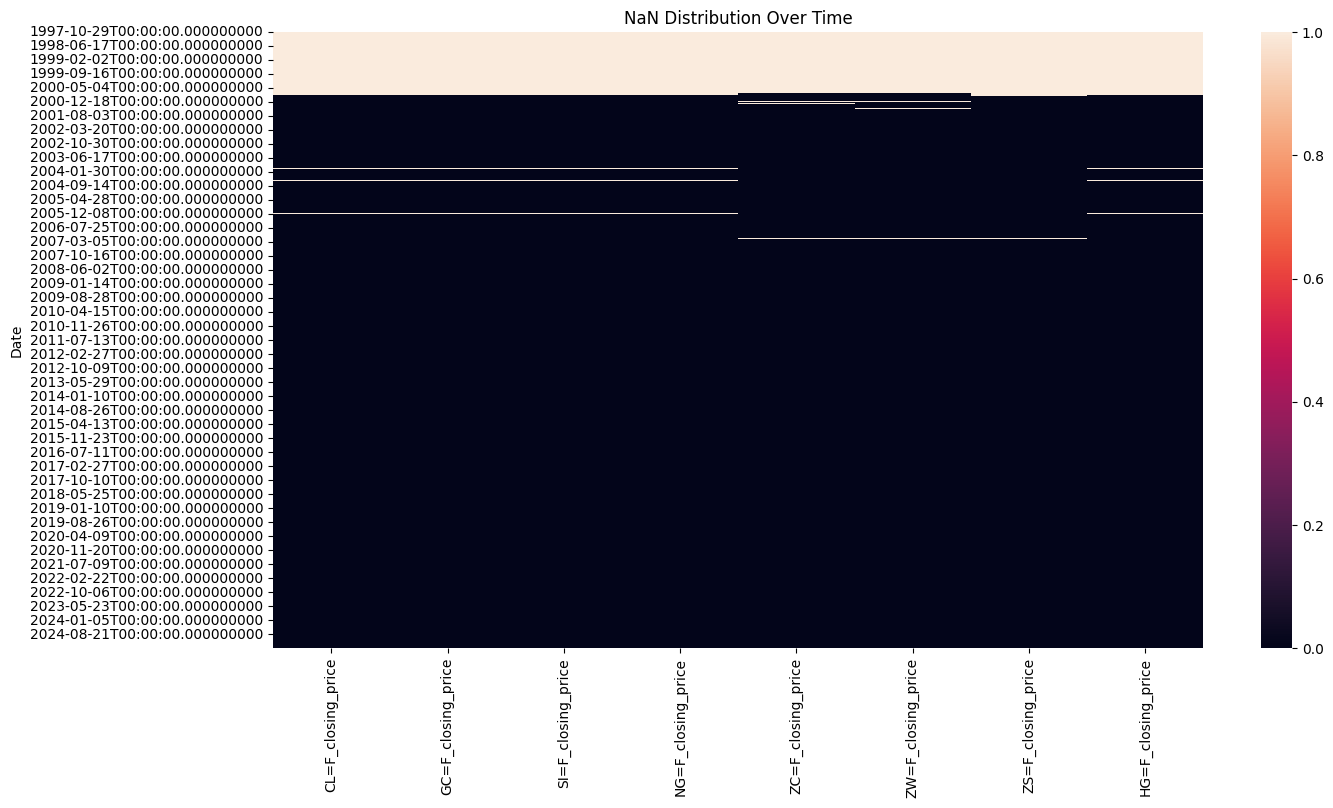

In [24]:
nan_distribution(df_futures)

In [25]:
df_futures.dropna(inplace=True)

In [26]:
df_futures.isna().any(axis=0).sum()

np.int64(0)

In [27]:
df_futures.head()

CL=F_closing_price  GC=F_closing_price  SI=F_closing_price  \
Date                                                                     
2000-09-18           36.880001          271.399994               4.876   
2000-09-19           36.500000          271.899994               4.883   
2000-09-20           37.500000          269.000000               4.830   
2000-09-21           33.950001          270.299988               4.872   
2000-09-22           32.650002          271.799988               4.910   

            NG=F_closing_price  ZC=F_closing_price  ZW=F_closing_price  \
Date                                                                     
2000-09-18               5.295              184.00              252.25   
2000-09-19               5.370              185.00              256.50   
2000-09-20               5.320              183.50              248.00   
2000-09-21               5.287              183.75              247.00   
2000-09-22               5.131              186.25              247.50   

            ZS=F_closing_price  HG=F_closing_price  
Date                                                
2000-09-18              484.00              0.9185  
2000-09-19              484.25              0.9215  
2000-09-20              483.25              0.9015  
2000-09-21              486.50              0.9255  
2000-09-22              491.00              0.9195

In [28]:
df_futures.tail()

CL=F_closing_price  GC=F_closing_price  SI=F_closing_price  \
Date                                                                     
2025-03-26           69.650002         3020.899902           34.033001   
2025-03-27           69.919998         3060.199951           34.896999   
2025-03-28           69.360001         3086.500000           34.644001   
2025-03-31           71.480003         3122.800049           34.457001   
2025-04-01           71.489998         3163.800049           34.759998   

            NG=F_closing_price  ZC=F_closing_price  ZW=F_closing_price  \
Date                                                                     
2025-03-26               3.861              451.25              535.25   
2025-03-27               3.950              450.00              532.00   
2025-03-28               4.065              453.25              528.25   
2025-03-31               4.119              457.25              537.00   
2025-04-01               4.069              467.75              552.25   

            ZS=F_closing_price  HG=F_closing_price  
Date                                                
2025-03-26             1001.00              5.2160  
2025-03-27             1016.75              5.0975  
2025-03-28             1023.00              5.1125  
2025-03-31             1014.75              5.0200  
2025-04-01             1032.00              5.0560

In [29]:
df_futures.shape

(6098, 8)

In [30]:
def line_plot(data):
    
    for column in data.columns:
        step = (max(data[column]) - min(data[column])) / 10
        sns.lineplot(data[column])
        plt.yticks(np.arange(start=min(data[column]) - step, stop=max(data[column])+step, step=step))
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.title(column)
        plt.tight_layout()
        plt.show()
        

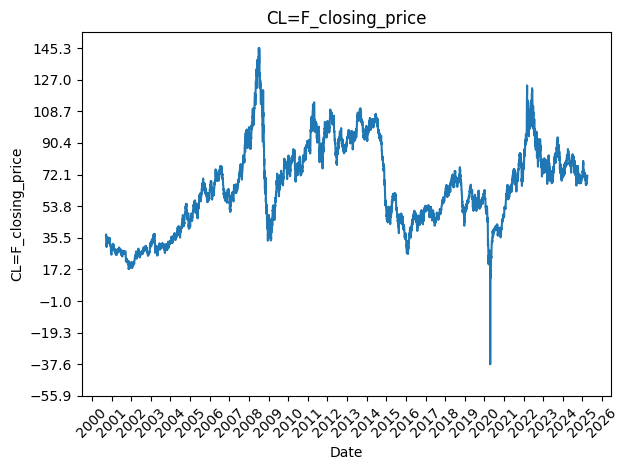

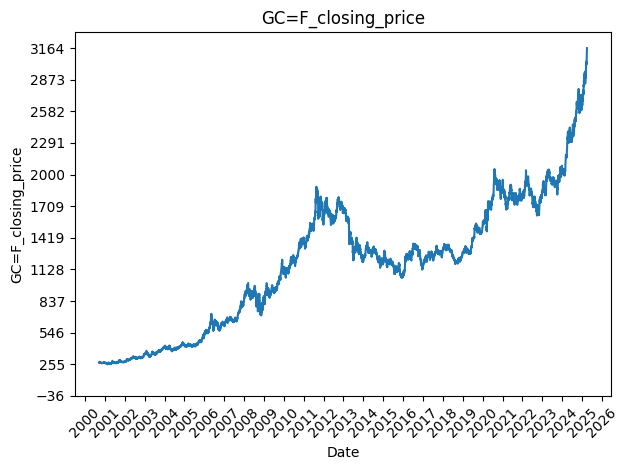

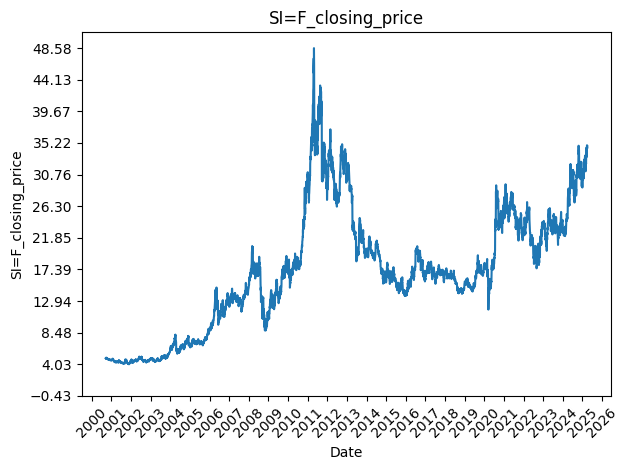

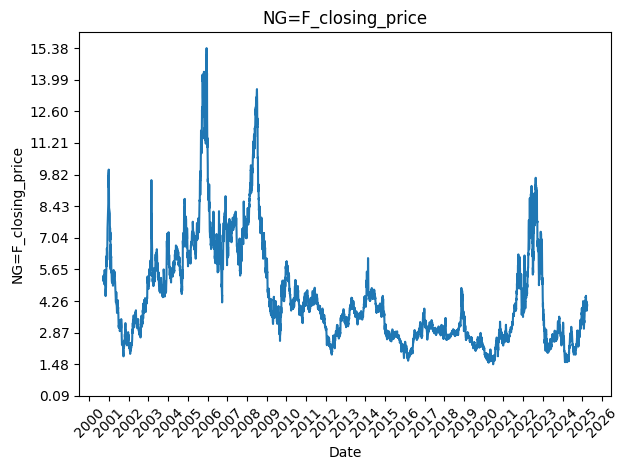

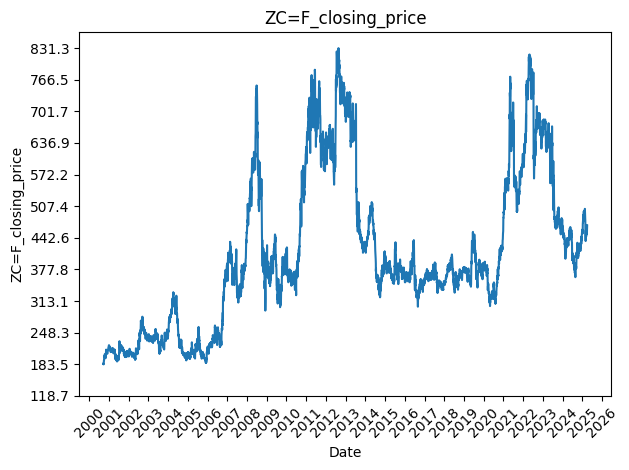

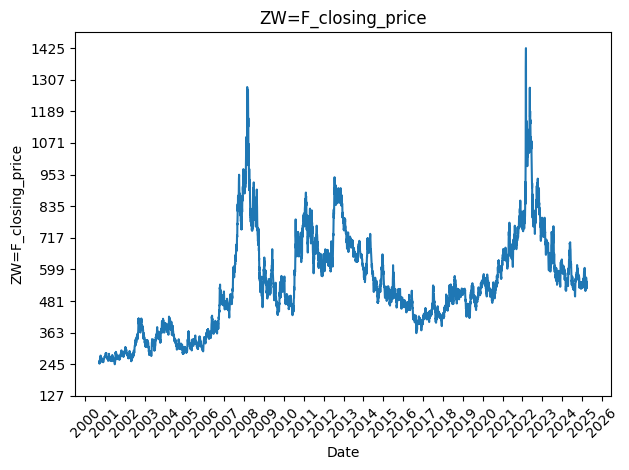

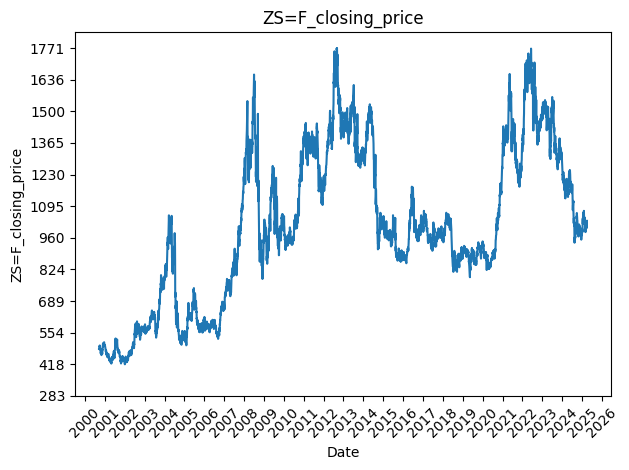

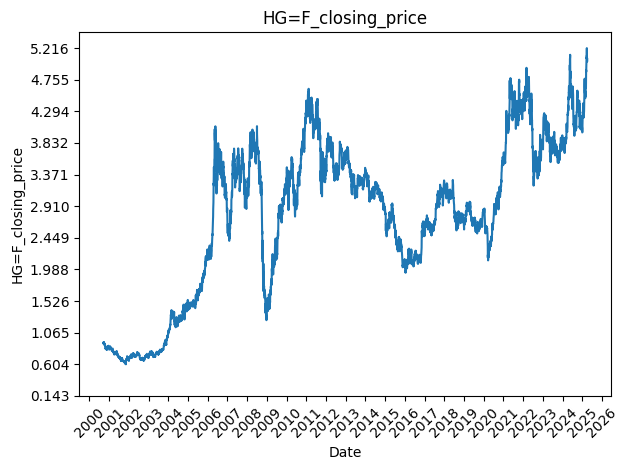

In [31]:
line_plot(df_futures)

In [32]:
df_futures_pct_change = df_futures.pct_change().dropna()

In [33]:
df_futures_pct_change.columns = ['CL %R', 'GC %R', 'SI %R', 'NG %R', 'ZC %R', 'ZW %R', 'ZS %R', 'HG %R']

In [34]:
df_futures_pct_change.head()

CL %R     GC %R     SI %R     NG %R     ZC %R     ZW %R  \
Date                                                                     
2000-09-19 -0.010304  0.001842  0.001436  0.014164  0.005435  0.016848   
2000-09-20  0.027397 -0.010666 -0.010854 -0.009311 -0.008108 -0.033138   
2000-09-21 -0.094667  0.004833  0.008696 -0.006203  0.001362 -0.004032   
2000-09-22 -0.038292  0.005549  0.007800 -0.029506  0.013605  0.002024   
2000-09-25 -0.033078  0.008462  0.001018  0.028260  0.000000  0.030303   

               ZS %R     HG %R  
Date                            
2000-09-19  0.000517  0.003266  
2000-09-20 -0.002065 -0.021704  
2000-09-21  0.006725  0.026622  
2000-09-22  0.009250 -0.006483  
2000-09-25  0.011202  0.008157

In [35]:
df_futures_pct_change.tail()

CL %R     GC %R     SI %R     NG %R     ZC %R     ZW %R  \
Date                                                                     
2025-03-26  0.009420 -0.000926  0.000912  0.005469 -0.014200 -0.014726   
2025-03-27  0.003876  0.013009  0.025387  0.023051 -0.002770 -0.006072   
2025-03-28 -0.008009  0.008594 -0.007250  0.029114  0.007222 -0.007049   
2025-03-31  0.030565  0.011761 -0.005398  0.013284  0.008825  0.016564   
2025-04-01  0.000140  0.013129  0.008793 -0.012139  0.022963  0.028399   

               ZS %R     HG %R  
Date                            
2025-03-26 -0.000749  0.006367  
2025-03-27  0.015734 -0.022719  
2025-03-28  0.006147  0.002943  
2025-03-31 -0.008065 -0.018093  
2025-04-01  0.016999  0.007171

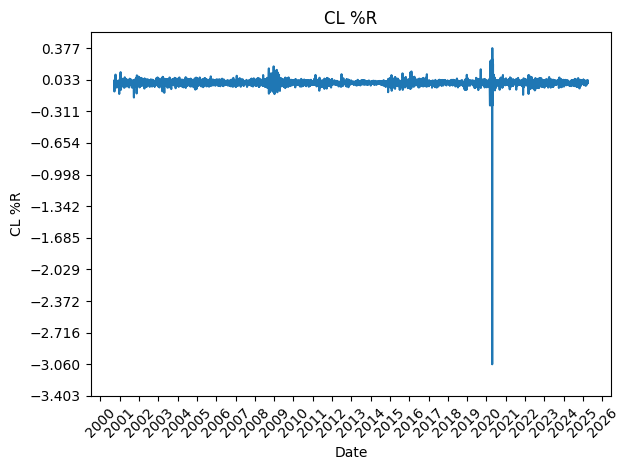

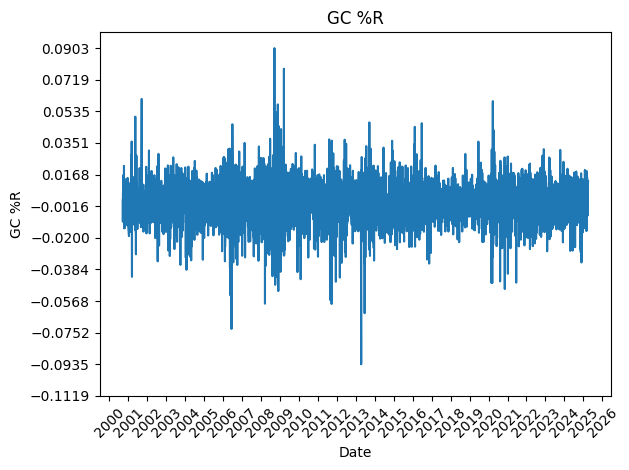

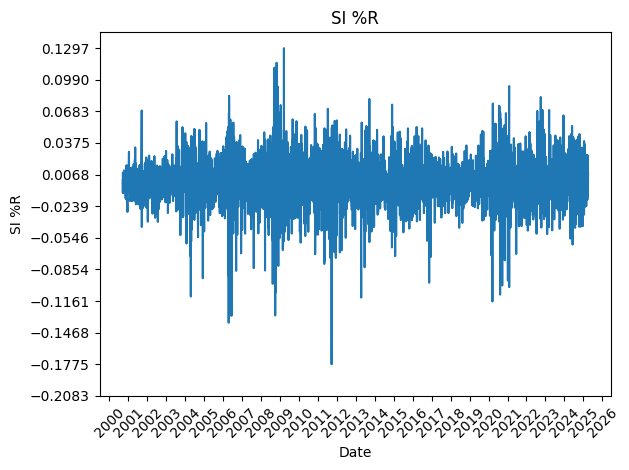

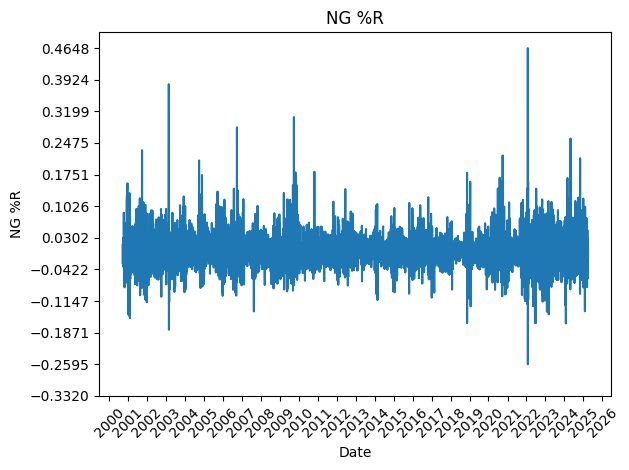

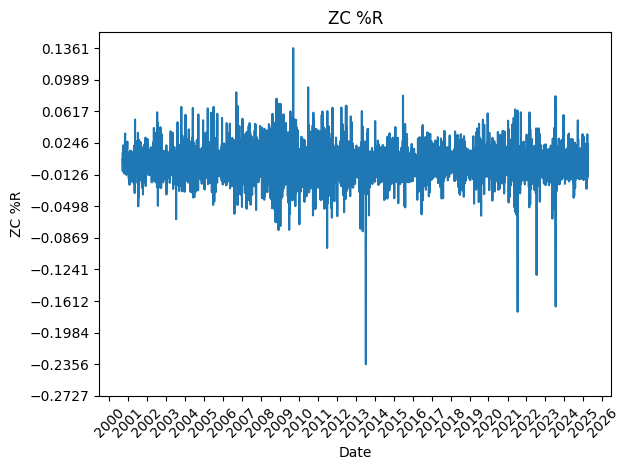

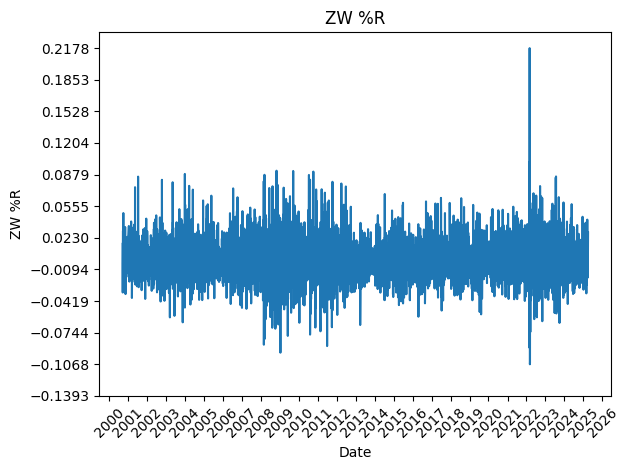

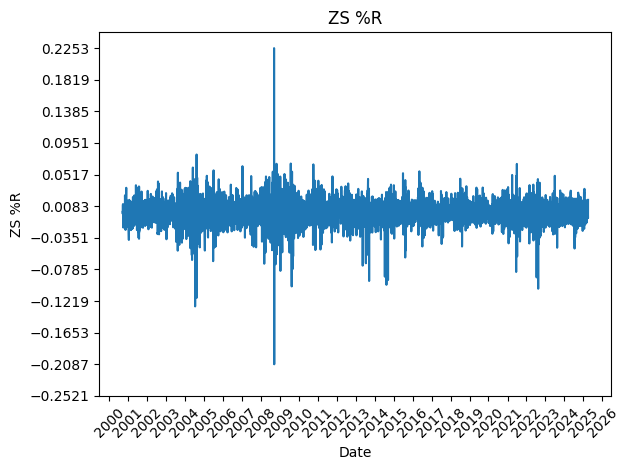

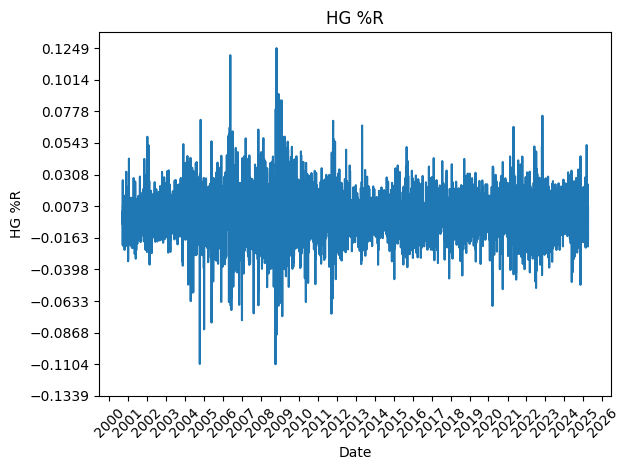

In [36]:
line_plot(df_futures_pct_change)

In [37]:
# US 10 Year Yields Data

In [38]:
df_us10y.head()

observation_date  DGS10
0       2000-09-18   5.88
1       2000-09-19   5.86
2       2000-09-20   5.91
3       2000-09-21   5.88
4       2000-09-22   5.85

In [39]:
df_us10y.tail()

observation_date  DGS10
6397       2025-03-26   4.35
6398       2025-03-27   4.38
6399       2025-03-28   4.27
6400       2025-03-31   4.23
6401       2025-04-01   4.17

In [40]:
df_us10y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6402 entries, 0 to 6401
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  6402 non-null   object 
 1   DGS10             6136 non-null   float64
dtypes: float64(1), object(1)
memory usage: 100.2+ KB


In [41]:
df_us10y['observation_date'] = pd.to_datetime(df_us10y['observation_date'])

In [42]:
df_us10y.set_index('observation_date', inplace=True)

In [43]:
df_us10y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6402 entries, 2000-09-18 to 2025-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DGS10   6136 non-null   float64
dtypes: float64(1)
memory usage: 100.0 KB


In [44]:
df_us10y.head()

DGS10
observation_date       
2000-09-18         5.88
2000-09-19         5.86
2000-09-20         5.91
2000-09-21         5.88
2000-09-22         5.85

In [45]:
df_us10y.isna().any(axis=0).sum()

np.int64(1)

In [46]:
df_us10y.dropna(inplace=True)

In [47]:
df_us10y.isna().any(axis=0).sum()

np.int64(0)

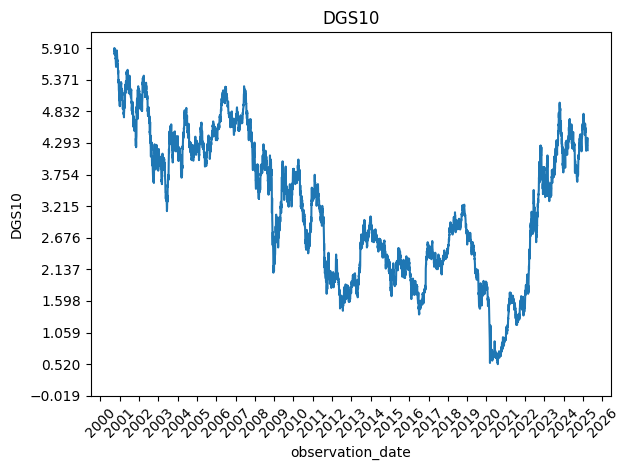

In [48]:
line_plot(df_us10y)

In [49]:
df_us10y.head()

DGS10
observation_date       
2000-09-18         5.88
2000-09-19         5.86
2000-09-20         5.91
2000-09-21         5.88
2000-09-22         5.85

In [50]:
df_us10y_pct_change = df_us10y.pct_change().dropna()

In [51]:
df_us10y_pct_change.columns = ['DGS10 %R']

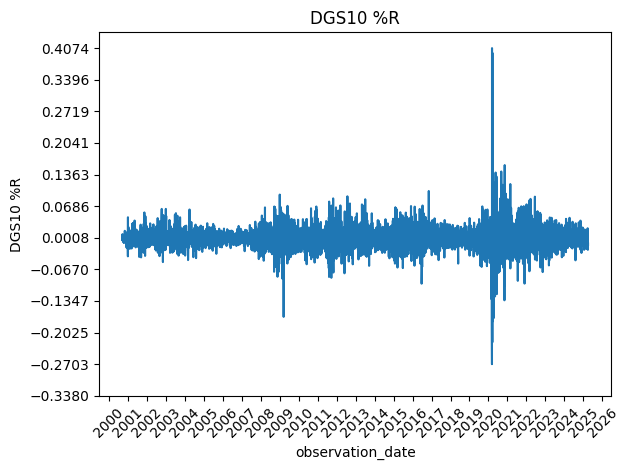

In [52]:
line_plot(df_us10y_pct_change)

In [53]:
# SPY data

In [54]:
def yf_asset_fetcher(ticker, date, timeframe):
    asset = yf.download(ticker, start=date, interval=timeframe)
    return asset

In [55]:
df_spy = yf_asset_fetcher('SPY', '2000-09-18', '1d')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [56]:
df_spy.head()

Price           Close       High        Low       Open   Volume
Ticker            SPY        SPY        SPY        SPY      SPY
Date                                                           
2000-09-18  92.601143  94.081481  92.311077  93.701394  5109300
2000-09-19  93.441277  93.661327  92.631092  92.901154  6588200
2000-09-20  92.751190  93.481357  91.640937  93.261307  6508100
2000-09-21  91.340851  93.181271  91.300842  92.481111  5972300
2000-09-22  93.001213  93.021218  91.170796  91.300825  7791300

In [57]:
df_spy.tail()

Price            Close        High         Low        Open     Volume
Ticker             SPY         SPY         SPY         SPY        SPY
Date                                                                 
2025-03-31  559.390015  560.710022  546.869995  549.830017   95328200
2025-04-01  560.969971  562.940002  553.679993  557.450012   54609600
2025-04-02  564.520020  567.419983  554.809998  555.049988   76014500
2025-04-03  536.700012  547.969971  536.700012  545.109985  125986000
2025-04-04  505.279999  525.869995  505.059998  523.669983  216189500

In [58]:
df_spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6174 entries, 2000-09-18 to 2025-04-04
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, SPY)   6174 non-null   float64
 1   (High, SPY)    6174 non-null   float64
 2   (Low, SPY)     6174 non-null   float64
 3   (Open, SPY)    6174 non-null   float64
 4   (Volume, SPY)  6174 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 289.4 KB


In [59]:
df_spy.shape

(6174, 5)

In [60]:
df_spy.isna().any(axis=0).sum()

np.int64(0)

In [61]:
df_spy.index

DatetimeIndex(['2000-09-18', '2000-09-19', '2000-09-20', '2000-09-21',
               '2000-09-22', '2000-09-25', '2000-09-26', '2000-09-27',
               '2000-09-28', '2000-09-29',
               ...
               '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27',
               '2025-03-28', '2025-03-31', '2025-04-01', '2025-04-02',
               '2025-04-03', '2025-04-04'],
              dtype='datetime64[ns]', name='Date', length=6174, freq=None)

In [62]:
df_spy.isna().any(axis=0).sum()

np.int64(0)

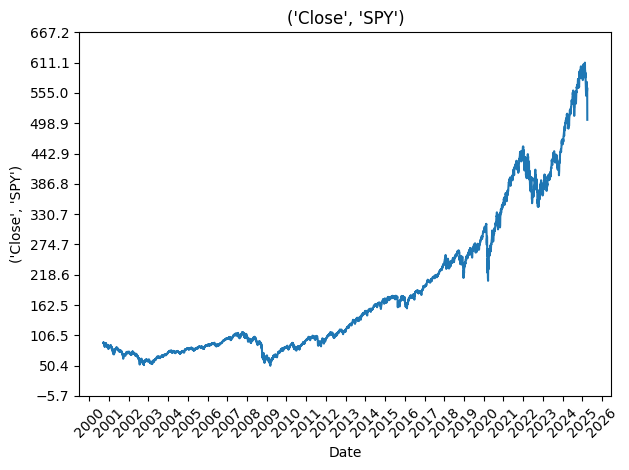

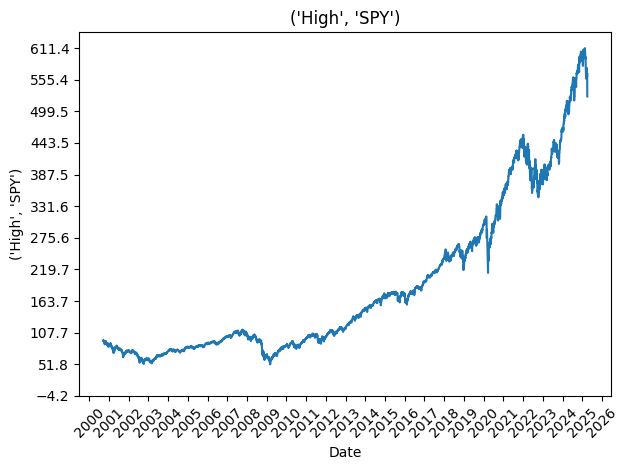

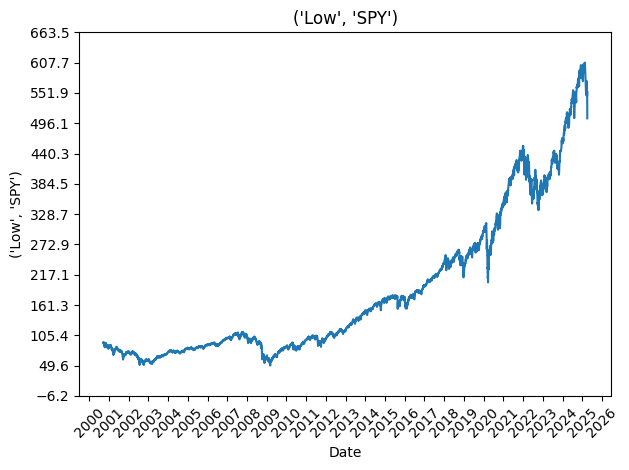

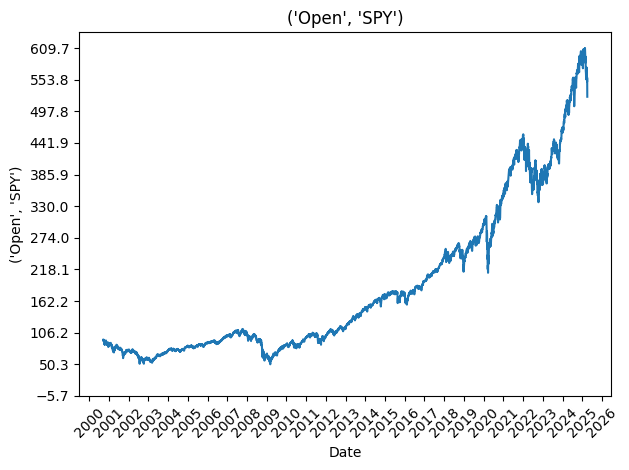

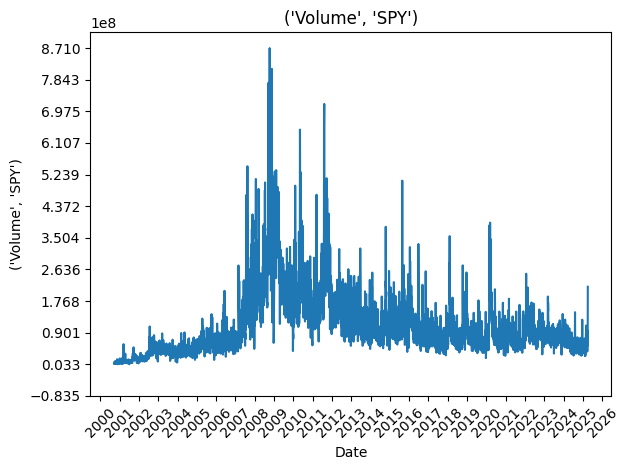

In [63]:
line_plot(df_spy)

In [64]:
df_spy_pct_change = pd.DataFrame(df_spy['Close', 'SPY'].pct_change().dropna())

In [65]:
df_spy_pct_change.columns = [('Close %R', 'SPY')]

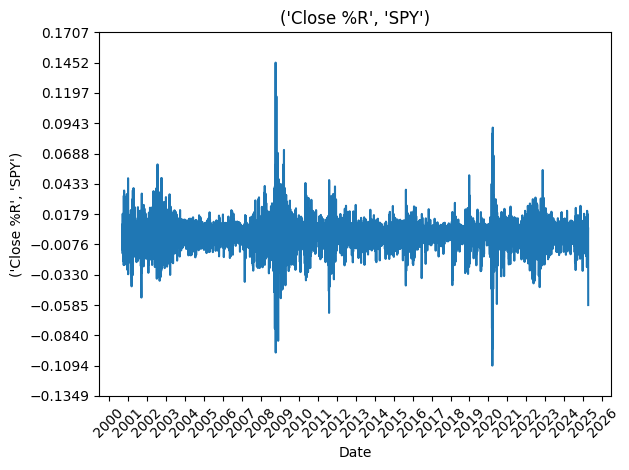

In [66]:
line_plot(df_spy_pct_change)

In [67]:
# EDA: data distribution analysis

In [68]:
def normal_distribution_analysis(data, plot=True):
    for column in data.columns:
        try:
            stat, p = normaltest(data[column])
            kurt = kurtosis(data[column], fisher=True)
            sk = skew(data[column])
            print(f"Distribution Analysis on {column}: ")
            print(f"D'Agostino-Pearson Test: ")
            print(f"    Stat: {stat:.4f}")
            print(f"    p-value: {p:.4f} \n")
            print(f"Kurtosis: {kurt:.4f}")
            print(f"Skew: {sk:.4f}")
            
            if plot is True:
                if is_numeric_dtype(data[column]):
                    plt.figure(figsize=(3,2))
                    sns.histplot(data[column], kde=True)
                    plt.show()
            print("_" * 20 + "\n")

        except (ValueError, AttributeError, TypeError):
            print("Could not perform the test. Check the type of the column's data. \n")
        

Distribution Analysis on CL %R: 
D'Agostino-Pearson Test: 
    Stat: 17875.1452
    p-value: 0.0000 

Kurtosis: 2401.0481
Skew: -40.5786


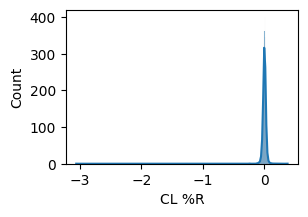

____________________

Distribution Analysis on GC %R: 
D'Agostino-Pearson Test: 
    Stat: 726.9717
    p-value: 0.0000 

Kurtosis: 5.1279
Skew: -0.1965


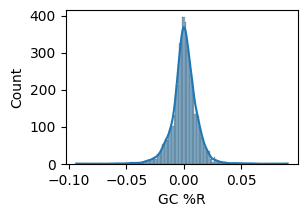

____________________

Distribution Analysis on SI %R: 
D'Agostino-Pearson Test: 
    Stat: 1029.4095
    p-value: 0.0000 

Kurtosis: 5.8988
Skew: -0.5446


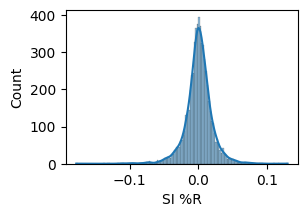

____________________

Distribution Analysis on NG %R: 
D'Agostino-Pearson Test: 
    Stat: 1716.7652
    p-value: 0.0000 

Kurtosis: 9.6868
Skew: 0.9467


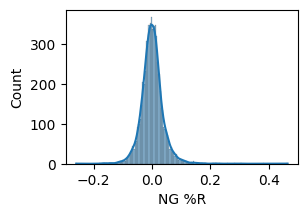

____________________

Distribution Analysis on ZC %R: 
D'Agostino-Pearson Test: 
    Stat: 1310.5987
    p-value: 0.0000 

Kurtosis: 9.9230
Skew: -0.5205


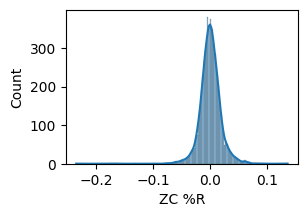

____________________

Distribution Analysis on ZW %R: 
D'Agostino-Pearson Test: 
    Stat: 720.5057
    p-value: 0.0000 

Kurtosis: 3.7055
Skew: 0.4564


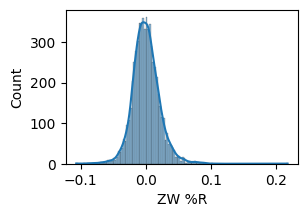

____________________

Distribution Analysis on ZS %R: 
D'Agostino-Pearson Test: 
    Stat: 1567.4415
    p-value: 0.0000 

Kurtosis: 15.3150
Skew: -0.5089


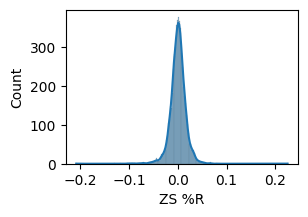

____________________

Distribution Analysis on HG %R: 
D'Agostino-Pearson Test: 
    Stat: 558.5023
    p-value: 0.0000 

Kurtosis: 3.9540
Skew: -0.0265


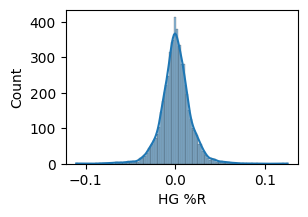

____________________



In [69]:
normal_distribution_analysis(df_futures_pct_change)

Distribution Analysis on DGS10 %R: 
D'Agostino-Pearson Test: 
    Stat: 2624.2693
    p-value: 0.0000 

Kurtosis: 33.5064
Skew: 1.0691


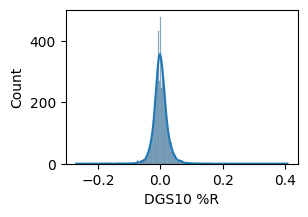

____________________



In [70]:
normal_distribution_analysis(df_us10y_pct_change)

Distribution Analysis on ('Close %R', 'SPY'): 
D'Agostino-Pearson Test: 
    Stat: 1198.4674
    p-value: 0.0000 

Kurtosis: 11.9891
Skew: -0.0549


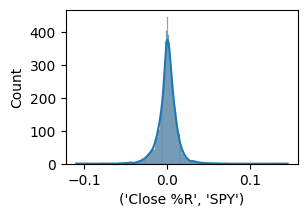

____________________



In [71]:
normal_distribution_analysis(df_spy_pct_change)

In [72]:
def other_distribution_analysis(data):
    
    for column in data.columns:
        col_data = data[column].dropna()
        if len(col_data) < 10:
            print(f"Skipping {column}: Too few valid data points ({len(col_data)})\n")
            continue
        try:
            print(f"Distribution Analysis on {column}: ")

            # Student's t
            df_t, loc_t, scale_t = t.fit(col_data)
            cdf_t = lambda x: t.cdf(x, df_t, loc_t, scale_t)
            stat_t, p_t = kstest(col_data, cdf_t)
            print("Student's t-distribution Test:")
            print(f"  df: {df_t:.4f}, loc: {loc_t:.4f}, scale: {scale_t:.4f}")
            print(f"  KS Statistic: {stat_t:.4f}, p-value: {p_t:.4f}\n")

            # Skew-Normal
            shape_sn, loc_sn, scale_sn = skewnorm.fit(col_data)
            cdf_sn = lambda x: skewnorm.cdf(x, shape_sn, loc_sn, scale_sn)
            stat_sn, p_sn = kstest(col_data, cdf_sn)
            print("Skew-normal Distribution Test:")
            print(f"  shape: {shape_sn:.4f}, loc: {loc_sn:.4f}, scale: {scale_sn:.4f}")
            print(f"  KS Statistic: {stat_sn:.4f}, p-value: {p_sn:.4f}\n")

            # Cauchy
            loc_c, scale_c = cauchy.fit(col_data)
            cdf_c = lambda x: cauchy.cdf(x, loc_c, scale_c)
            stat_c, p_c = kstest(col_data, cdf_c)
            print("Cauchy Distribution Test:")
            print(f"  loc: {loc_c:.4f}, scale: {scale_c:.4f}")
            print(f"  KS Statistic: {stat_c:.4f}, p-value: {p_c:.4f}\n")

            # Logistic
            loc_l, scale_l = logistic.fit(col_data)
            cdf_l = lambda x: logistic.cdf(x, loc_l, scale_l)
            stat_l, p_l = kstest(col_data, cdf_l)
            print("Logistic Distribution Test:")
            print(f"  loc: {loc_l:.4f}, scale: {scale_l:.4f}")
            print(f"  KS Statistic: {stat_l:.4f}, p-value: {p_l:.4f}\n")

            # Best fit
            results = {
                "Student's t": (stat_t, p_t),
                "Skew-Normal": (stat_sn, p_sn),
                "Cauchy": (stat_c, p_c),
                "Logistic": (stat_l, p_l)
            }
            best_fit = min(results, key=lambda k: results[k][0])
            print(f"Best Fit (lowest KS Stat): {best_fit}")
            print("Note: p-values may be low due to large sample size (n > 6000); compare KS Stats.")
            print("_" * 20 + "\n")

        except (ValueError, AttributeError, TypeError) as e:
            print(f"Could not perform the test for column '{column}': {e}\n")
     

In [73]:
other_distribution_analysis(df_futures_pct_change)

Distribution Analysis on CL %R: 
Student's t-distribution Test:
  df: 3.5375, loc: 0.0008, scale: 0.0171
  KS Statistic: 0.0103, p-value: 0.5369

Skew-normal Distribution Test:
  shape: -2.5560, loc: 0.0383, scale: 0.0629
  KS Statistic: 0.2014, p-value: 0.0000

Cauchy Distribution Test:
  loc: 0.0012, scale: 0.0121
  KS Statistic: 0.0572, p-value: 0.0000

Logistic Distribution Test:
  loc: 0.0006, scale: 0.0134
  KS Statistic: 0.0292, p-value: 0.0001

Best Fit (lowest KS Stat): Student's t
Note: p-values may be low due to large sample size (n > 6000); compare KS Stats.
____________________

Distribution Analysis on GC %R: 
Student's t-distribution Test:
  df: 3.6882, loc: 0.0007, scale: 0.0076
  KS Statistic: 0.0133, p-value: 0.2292

Skew-normal Distribution Test:
  shape: -0.9773, loc: 0.0077, scale: 0.0131
  KS Statistic: 0.0649, p-value: 0.0000

Cauchy Distribution Test:
  loc: 0.0006, scale: 0.0052
  KS Statistic: 0.0555, p-value: 0.0000

Logistic Distribution Test:
  loc: 0.0006,

In [74]:
other_distribution_analysis(df_us10y_pct_change)

Distribution Analysis on DGS10 %R: 
Student's t-distribution Test:
  df: 3.4258, loc: -0.0003, scale: 0.0152
  KS Statistic: 0.0447, p-value: 0.0000

Skew-normal Distribution Test:
  shape: 0.9736, loc: -0.0156, scale: 0.0289
  KS Statistic: 0.0731, p-value: 0.0000

Cauchy Distribution Test:
  loc: -0.0007, scale: 0.0107
  KS Statistic: 0.0559, p-value: 0.0000

Logistic Distribution Test:
  loc: -0.0001, scale: 0.0116
  KS Statistic: 0.0498, p-value: 0.0000

Best Fit (lowest KS Stat): Student's t
Note: p-values may be low due to large sample size (n > 6000); compare KS Stats.
____________________



In [75]:
other_distribution_analysis(df_spy_pct_change)

Distribution Analysis on ('Close %R', 'SPY'): 
Student's t-distribution Test:
  df: 2.6301, loc: 0.0008, scale: 0.0070
  KS Statistic: 0.0190, p-value: 0.0226

Skew-normal Distribution Test:
  shape: -0.9012, loc: 0.0079, scale: 0.0143
  KS Statistic: 0.0904, p-value: 0.0000

Cauchy Distribution Test:
  loc: 0.0009, scale: 0.0049
  KS Statistic: 0.0471, p-value: 0.0000

Logistic Distribution Test:
  loc: 0.0006, scale: 0.0059
  KS Statistic: 0.0506, p-value: 0.0000

Best Fit (lowest KS Stat): Student's t
Note: p-values may be low due to large sample size (n > 6000); compare KS Stats.
____________________



In [76]:
def extreme_distribution_analysis(data):
    
    for column in data.columns:
        
        thresh_pos = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
        results_pos = []
        
        thresh_neg = [-0.01, -0.015, -0.02, -0.025, -0.03, -0.035, -0.04, -0.045, -0.05]
        results_neg = []
        
        timeframe = ['W', 'ME']

        print(f"Extreme Distribution Analysis for: {column} \n")

        # Generalized Pareto Distribution

        for i in thresh_pos:
            pos_exceedances = data[column][data[column] > i] - i
            if len(pos_exceedances) > 10:
                c_pos, loc_pos, scale_pos = genpareto.fit(pos_exceedances, floc=0)
                cdf_pos = lambda x: genpareto.cdf(x, c_pos, loc=0, scale=scale_pos)
                stat_pos, p_pos = kstest(pos_exceedances, cdf_pos)

                results_pos.append({
                    "threshold": i,
                    "shape": c_pos,
                    "scale": scale_pos,
                    "ks_stat": stat_pos,
                    "p_value": p_pos,
                    "exceedances": len(pos_exceedances)
                })

        if results_pos:
            print("+++ Generalized Pareto Distribution for (Positive Tails)")
            for result in results_pos:
                print(f"  Threshold > {result['threshold']}:")
                print(f"    Shape (ξ): {result['shape']:.4f}, Scale: {result['scale']:.4f}")
                print(f"    KS Stat: {result['ks_stat']:.4f}, p-value: {result['p_value']:.4f}")
                print(f"    Exceedances: {result['exceedances']} \n")

        for i in thresh_neg:
            neg_exceedances = abs(data[column][data[column] < i] - i)
            if len(neg_exceedances) > 10:
                c_neg, loc_neg, scale_neg = genpareto.fit(neg_exceedances, floc=0)
                cdf_neg = lambda x: genpareto.cdf(x, c_neg, loc=0, scale=scale_neg)
                stat_neg, p_neg = kstest(neg_exceedances, cdf_neg)

                results_neg.append({
                    "threshold": i,
                    "shape": c_neg,
                    "scale": scale_neg,
                    "ks_stat": stat_neg,
                    "p_value": p_neg,
                    "exceedances": len(neg_exceedances)
                })

        if results_neg:
            print(f"--- Generalized Pareto Distribution for: {column} (Negative Tails)")
            for result in results_neg:
                print(f"  Threshold < {result['threshold']}:")
                print(f"    Shape (ξ): {result['shape']:.4f}, Scale: {result['scale']:.4f}")
                print(f"    KS Stat: {result['ks_stat']:.4f}, p-value: {result['p_value']:.4f}")
                print(f"    Exceedances: {result['exceedances']} \n")

        # Generalized Extreme Value Distribution
        
        for i in timeframe:
            
            timeframe_max = data[column].resample(i).max().dropna()
            c_max, loc_max, scale_max = genextreme.fit(timeframe_max)
            stat_max, p_max = kstest(timeframe_max, "genextreme", args=(c_max, loc_max, scale_max))
            print(f"+++ GEV Weekly Maxima (n = {len(timeframe_max)}):" if i == 'W' else f"+++ GEV Monthly Maxima (n = {len(timeframe_max)}):")
            print(f"  Shape (ξ): {c_max:.4f}, Loc: {loc_max:.4f}, Scale: {scale_max:.4f}")
            print(f"  KS Stat: {stat_max:.4f}, p-value: {p_max:.4f}\n")

            timeframe_min = -data[column].resample(i).min().dropna()
            c_min, loc_min, scale_min = genextreme.fit(timeframe_min)
            stat_min, p_min = kstest(timeframe_min, "genextreme", args=(c_min, loc_min, scale_min))
            print(f"--- GEV Weekly Minima (n = {len(timeframe_min)}):" if i == 'W' else f"--- GEV Monthly Minima (n = {len(timeframe_min)}):")
            print(f"  Shape (ξ): {c_min:.4f}, Loc: {loc_min:.4f}, Scale: {scale_min:.4f}")
            print(f"  KS Stat: {stat_min:.4f}, p-value: {p_min:.4f}\n")
                
        print("_" * 20 + "\n")

In [120]:
def time_windows(data, start=None, end=None, intervals=None, timeframe='y', analysis_func=None, slice=True):

    data = pd.DataFrame(data)
    if intervals is None:
        intervals = [1, 2, 5]

    if start is None and end is None:

        if timeframe.upper()=='Y':
            
            time_min = data.index.min().year 
            time_max = data.index.max().year

        elif timeframe.upper()=='M':
            
            time_min = data.index.min().month 
            time_max = data.index.max().month

        elif timeframe.upper()=='D':
            
            time_min = data.index.min().day 
            time_max = data.index.max().day

        if slice is True: #Separates the dataset per each column to be processed individually per each interval

            for column in data.columns:
                
                for interval in intervals:
                    for time in range(time_min, time_max - interval + 2):
                        start_time = str(time)
                        end_time = str(time + interval - 1)
                        slice_df = pd.DataFrame(data[column].loc[start_time:end_time])
        
                        print(f"Time Window: {interval} {timeframe.upper()} from {start_time} to {end_time}")
        
                        if analysis_func is not None:
                            analysis_results = analysis_func(slice_df)
                            
                        else:
                            print(slice_df)
        
                        print("\n")
        else: #Process all columns of the dataset at once per each interval

            for interval in intervals:
                    for time in range(time_min, time_max - interval + 2):
                        start_time = str(time)
                        end_time = str(time + interval - 1)
                        slice_df = pd.DataFrame(data.loc[start_time:end_time])
        
                        print(f"Time Window: {interval} years from {start_time} to {end_time}")
        
                        if analysis_func is not None:
                            analysis_results = analysis_func(slice_df)
                            
                        else:
                            print(slice_df)
        
                        print("\n")
            
                    
    else:
        slice_df = pd.DataFrame(data.loc[str(start):str(end)])
        print(f"Time Window: {start} to {end}")

        if analysis_func is not None:
            analysis_results = analysis_func(slice_df)
            
        else:
            print(slice_df)

In [81]:
def runs_test(data):
    
    for column in data.columns:
        median_return = np.median(data[column])
        binary = (data[column] > median_return).astype(int).to_numpy()
        runs = Runs(binary)
        stat, pval = runs.runs_test()
        print(f"Runs Test on {column}: Statistic = {stat:.3f}, P-value = {pval:.3f}")

In [82]:
def hill_estimator(data, k_fraction=0.1, threshold=0.02):
    for column in data.columns:
        # Negative tail (returns < -threshold)
        neg_tail = -data[column][data[column] < -threshold].to_numpy()  # Flip to positive
        neg_n = len(neg_tail)
        if neg_n < 2:
            print(f"{column} Negative Tail (< -{threshold}): Too few exceedances ({neg_n})")
            continue
        neg_k = max(1, int(neg_n * k_fraction))
        if neg_k >= neg_n:
            print(f"{column} Negative Tail (< -{threshold}): k ({neg_k}) >= n ({neg_n}), skipping")
            continue
        sorted_neg = np.sort(neg_tail)[::-1]  # Descending: 3.06, ..., 0.021
        neg_top_k = sorted_neg[:neg_k]  # Top k
        neg_hill = 1 / np.mean(np.log(neg_top_k / threshold))  # Fixed threshold
        print(f"{column} Negative Tail (< -{threshold}): Hill ξ = {neg_hill:.4f}, Exceedances = {neg_n}, k = {neg_k}")

        # Positive tail (returns > threshold)
        pos_tail = data[column][data[column] > threshold].to_numpy()
        pos_n = len(pos_tail)
        if pos_n < 2:
            print(f"{column} Positive Tail (> {threshold}): Too few exceedances ({pos_n})")
            continue
        pos_k = max(1, int(pos_n * k_fraction))
        if pos_k >= pos_n:
            print(f"{column} Positive Tail (> {threshold}): k ({pos_k}) >= n ({pos_n}), skipping")
            continue
        sorted_pos = np.sort(pos_tail)[::-1]  # Descending
        pos_top_k = sorted_pos[:pos_k]
        pos_hill = 1 / np.mean(np.log(pos_top_k / threshold))  # Fixed threshold
        print(f"{column} Positive Tail (> {threshold}): Hill ξ = {pos_hill:.4f}, Exceedances = {pos_n}, k = {pos_k} \n")

In [103]:
def correlations(data, method='pearson', plot=False):
    
    corr_matrix = data.corr(method)
    print(f"Correlation Matrix, method: {method} \n {corr_matrix}")
    if plot == True:
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Multi-Asset Correlations (t)")
        plt.show()

In [84]:
corr_data = pd.concat([df_us10y_pct_change, df_futures_pct_change, df_spy_pct_change], axis=1, join='inner')

In [242]:
def correlations2(data, method='pearson', plot=False, lag=1):
    """
    Compute cross-lagged correlations between data at time t and lagged data at t-lag,
    excluding self-lagged correlations.
    
    Parameters:
    - data: pandas DataFrame with time index and multiple columns (can include tuple names)
    - method: correlation method ('pearson', 'spearman', 'kendall')
    - plot: bool, whether to display a heatmap
    - lag: int, number of periods to shift for lagging (default 1)
    """
    # Ensure data is a DataFrame
    data = pd.DataFrame(data)
    if data.empty or len(data) < 2:
        print("Data too small to compute lagged correlation")
        return pd.DataFrame()

    # Create lagged version of the data
    lagged_data = data.shift(lag)
    
    # Drop rows with NaN values (due to shifting)
    combined = pd.concat([data, lagged_data], axis=1).dropna()
    
    # Separate back into current and lagged after dropping NaNs
    n_cols = data.shape[1]
    data_t = combined.iloc[:, :n_cols]
    data_t_minus_1 = combined.iloc[:, n_cols:]
    
    # Preserve original columns in data_t
    data_t.columns = data.columns
    
    # Convert all column names to strings for corr_matrix, but preserve original for access
    data_cols_str = [col if isinstance(col, str) else str(col) for col in data.columns]
    lagged_cols_str = [f"{col}_lag{lag}" if isinstance(col, str) else f"{str(col)}_lag{lag}" for col in data.columns]
    data_t_minus_1.columns = lagged_cols_str
    
    # Compute cross-lagged correlations (excluding self-lagged pairs)
    corr_matrix = pd.DataFrame(index=data_cols_str, columns=lagged_cols_str)
    for col_t, col_t_str in zip(data_t.columns, data_cols_str):
        for col_t_minus_1 in data_t_minus_1.columns:
            corr_matrix.loc[col_t_str, col_t_minus_1] = data_t[col_t].corr(
                    data_t_minus_1[col_t_minus_1], method=method
                )
    
    print(f"Cross-Lagged Correlation Matrix (t vs t-{lag}), method: {method}")
    print(corr_matrix)
    
    if plot:
        # Heatmap of the cross-lagged correlation matrix
        sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f"Multi-Asset Cross-Lagged Correlations (t vs t-{lag})")
        plt.show()
    
    return corr_matrix


Time Window: 2025-03-18 to 2025-03-21
Cross-Lagged Correlation Matrix (t vs t-1), method: spearman
                    DGS10 %R_lag1 CL %R_lag1 GC %R_lag1 SI %R_lag1 NG %R_lag1  \
DGS10 %R                      0.5        1.0       -0.5       -0.5       -0.5   
CL %R                        -1.0       -0.5       -0.5       -0.5        1.0   
GC %R                        -1.0       -0.5       -0.5       -0.5        1.0   
SI %R                        -0.5        0.5       -1.0       -1.0        0.5   
NG %R                         0.5       -0.5        1.0        1.0       -0.5   
ZC %R                        -1.0       -0.5       -0.5       -0.5        1.0   
ZW %R                         1.0        0.5        0.5        0.5       -1.0   
ZS %R                        -0.5        0.5       -1.0       -1.0        0.5   
HG %R                        -0.5       -1.0        0.5        0.5        0.5   
('Close %R', 'SPY')           0.5       -0.5        1.0        1.0       -0.5   

         

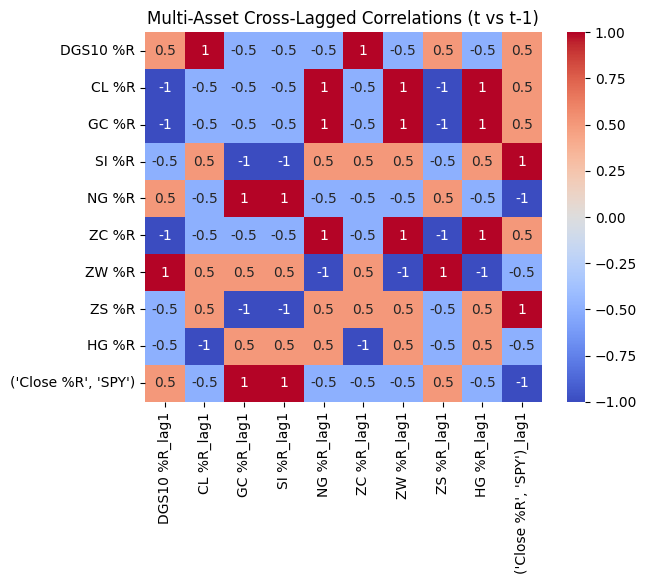

In [246]:
time_windows(corr_data, start='2025-03-18', end='2025-03-21', intervals=[1], analysis_func=lambda x:correlations2(x, method='spearman', plot=True), slice=False)

Time Window: 2025-03-20 to 2025-03-25
Correlation Matrix, method: spearman 
                  DGS10 %R  CL %R  GC %R  SI %R  NG %R  ZC %R  ZW %R  ZS %R  \
DGS10 %R              1.0    0.4   -0.8   -0.4    0.6    0.4   -0.4    0.4   
CL %R                 0.4    1.0   -0.2   -0.4   -0.4    1.0   -0.6    1.0   
GC %R                -0.8   -0.2    1.0    0.8   -0.8   -0.2   -0.2   -0.2   
SI %R                -0.4   -0.4    0.8    1.0   -0.4   -0.4   -0.4   -0.4   
NG %R                 0.6   -0.4   -0.8   -0.4    1.0   -0.4    0.4   -0.4   
ZC %R                 0.4    1.0   -0.2   -0.4   -0.4    1.0   -0.6    1.0   
ZW %R                -0.4   -0.6   -0.2   -0.4    0.4   -0.6    1.0   -0.6   
ZS %R                 0.4    1.0   -0.2   -0.4   -0.4    1.0   -0.6    1.0   
HG %R                -1.0   -0.4    0.8    0.4   -0.6   -0.4    0.4   -0.4   
(Close %R, SPY)       0.4   -0.4    0.0    0.6    0.4   -0.4   -0.4   -0.4   

                 HG %R  (Close %R, SPY)  
DGS10 %R          -1.0

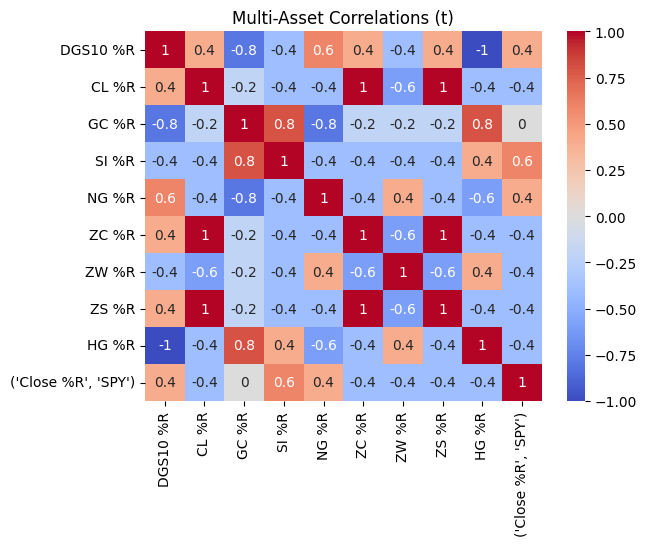

In [107]:
time_windows(corr_data, start='2025-03-20', end='2025-03-25', intervals=[1], analysis_func=lambda x:correlations(x, method='spearman', plot=True), slice=False)

Time Window: 2025-03-25 to 2025-04-01
Correlation Matrix, method: spearman 
                  DGS10 %R     CL %R     GC %R     SI %R     NG %R     ZC %R  \
DGS10 %R         1.000000  0.542857 -0.428571  0.542857 -0.257143 -0.657143   
CL %R            0.542857  1.000000  0.028571  0.028571 -0.028571  0.142857   
GC %R           -0.428571  0.028571  1.000000  0.257143  0.142857  0.771429   
SI %R            0.542857  0.028571  0.257143  1.000000 -0.428571 -0.371429   
NG %R           -0.257143 -0.028571  0.142857 -0.428571  1.000000  0.257143   
ZC %R           -0.657143  0.142857  0.771429 -0.371429  0.257143  1.000000   
ZW %R           -0.542857  0.142857  0.942857  0.028571  0.085714  0.885714   
ZS %R           -0.200000 -0.371429  0.600000  0.314286  0.142857  0.371429   
HG %R           -0.085714 -0.428571 -0.314286  0.085714 -0.828571 -0.257143   
(Close %R, SPY) -0.085714  0.485714  0.485714  0.200000 -0.485714  0.428571   

                    ZW %R     ZS %R     HG %R  (Close

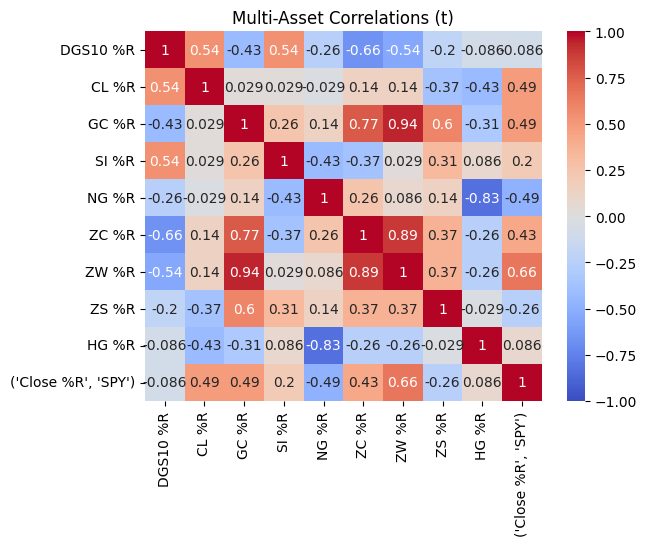

In [109]:
time_windows(corr_data, start='2025-03-25', end='2025-04-01', intervals=[1], analysis_func=lambda x:correlations(x, method='spearman', plot=True), slice=False)

Time Window: 2024-07-22 to 2024-07-26
Correlation Matrix, method: spearman 
                  DGS10 %R  CL %R  GC %R  SI %R  NG %R  ZC %R  ZW %R  ZS %R  \
DGS10 %R              1.0    0.6   -0.6   -0.5   -0.2    0.3    0.8    0.4   
CL %R                 0.6    1.0   -0.8   -0.7   -0.6   -0.1    0.1    0.3   
GC %R                -0.6   -0.8    1.0    0.7    0.4   -0.5   -0.4   -0.8   
SI %R                -0.5   -0.7    0.7    1.0    0.9   -0.1   -0.1   -0.3   
NG %R                -0.2   -0.6    0.4    0.9    1.0    0.3    0.3    0.1   
ZC %R                 0.3   -0.1   -0.5   -0.1    0.3    1.0    0.7    0.9   
ZW %R                 0.8    0.1   -0.4   -0.1    0.3    0.7    1.0    0.6   
ZS %R                 0.4    0.3   -0.8   -0.3    0.1    0.9    0.6    1.0   
HG %R                -0.7    0.1   -0.1   -0.1   -0.3   -0.2   -0.8    0.0   
(Close %R, SPY)      -0.7   -0.6    0.5    0.9    0.8    0.0   -0.3   -0.1   

                 HG %R  (Close %R, SPY)  
DGS10 %R          -0.7

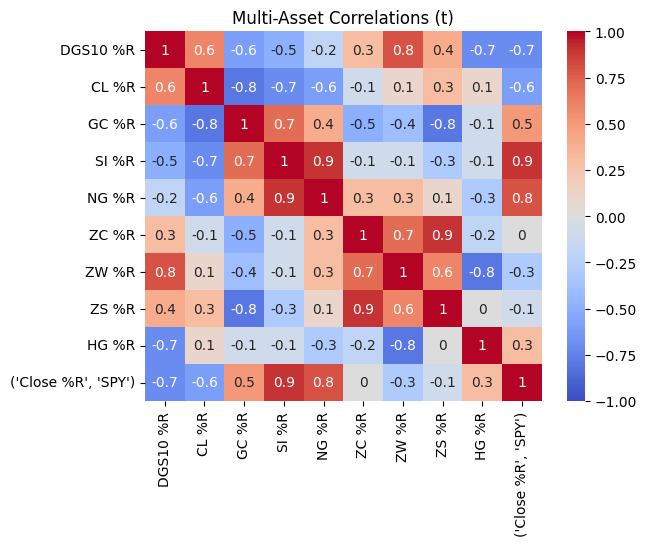

In [111]:
time_windows(corr_data, start='2024-07-22', end='2024-07-26', intervals=[1], analysis_func=lambda x:correlations(x, method='spearman', plot=True), slice=False)

In [166]:
df_futures.index

DatetimeIndex(['2000-09-18', '2000-09-19', '2000-09-20', '2000-09-21',
               '2000-09-22', '2000-09-25', '2000-09-26', '2000-09-27',
               '2000-09-28', '2000-09-29',
               ...
               '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24',
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-03-31', '2025-04-01'],
              dtype='datetime64[ns]', name='Date', length=6098, freq=None)

In [268]:
def plot_correlation_evolution(data, window_size, step_size=1, start=None, end=None, method='spearman', lag=1, filter_threshold=None):
    """
    Plot the evolution of cross-lagged correlations over time using overlapping windows, with filtering based on correlation values.
    
    Parameters:
    - data: pandas DataFrame with time index and multiple columns (can include tuple names)
    - window_size: int, size of the time window (in days, months, or years based on timeframe)
    - step_size: int, step size for overlapping windows (default 1)
    - start: str or datetime, start date (default: min date in data)
    - end: str or datetime, end date (default: max date in data)
    - method: correlation method ('pearson', 'spearman', 'kendall')
    - lag: int, number of periods to shift for lagging (default 1)
    - filter_threshold: float or None, threshold for filtering pairs based on correlation values
                        - If None, plot all pairs
                        - If float (e.g., 0.5), only plot pairs where at least one correlation value
                          is >= filter_threshold or <= -filter_threshold
    """
    # Ensure data is a DataFrame with DatetimeIndex
    data = pd.DataFrame(data)
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("Data index must be a DatetimeIndex")

    # Set start and end if not provided
    start = pd.to_datetime(start) if start else data.index.min()
    end = pd.to_datetime(end) if end else data.index.max()
    data = data.loc[start:end]

    # Generate overlapping windows
    date_range = pd.date_range(start=start, end=end, freq='D')
    windows = []
    for i in range(0, len(date_range) - window_size + 1, step_size):
        window_start = date_range[i]
        window_end = window_start + pd.Timedelta(days=window_size - 1)
        if window_end > end:
            continue
        windows.append((window_start, window_end))

    # Compute correlations for each window
    corr_evolution = []
    for window_start, window_end in windows:
        slice_df = data.loc[window_start:window_end]
        if len(slice_df) < 2:
            continue  # Skip windows with insufficient data
        corr_matrix = correlations2(slice_df, method=method, plot=False, lag=lag)
        # Flatten the correlation matrix into a Series with MultiIndex
        corr_series = corr_matrix.stack()
        corr_series.index = pd.MultiIndex.from_tuples(
            [(window_start, *pair) for pair in corr_series.index],
            names=['window_start', 'col_t', 'col_t_minus_1']
        )
        corr_evolution.append(corr_series)

    # Combine into a DataFrame
    if not corr_evolution:
        print("No valid windows to compute correlations.")
        return
    corr_evolution_df = pd.concat(corr_evolution).unstack(level=['col_t', 'col_t_minus_1'])

    # Apply filter based on correlation values
    pairs_to_plot = corr_evolution_df.columns
    if filter_threshold is not None:
        # Only plot pairs where at least one correlation value is >= filter_threshold or <= -filter_threshold
        pairs_to_plot = [
            pair for pair in corr_evolution_df.columns
            if (corr_evolution_df[pair] >= filter_threshold).any() or (corr_evolution_df[pair] <= -filter_threshold).any()
        ]

    if not pairs_to_plot:
        print(f"No pairs have correlations >= {filter_threshold} or <= {-filter_threshold}.")
        return

    # Plot the evolution of filtered correlations
    plt.figure(figsize=(12, 8))
    for pair in pairs_to_plot:
        plt.plot(
            corr_evolution_df.index,
            corr_evolution_df[pair],
            label=f"{pair[0]} vs {pair[1]}",
            marker='o'
        )
    
    plt.title(f"Evolution of Cross-Lagged Correlations (Window Size: {window_size} days, Method: {method})")
    plt.xlabel("Window Start Date")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

    return corr_evolution_df

Cross-Lagged Correlation Matrix (t vs t-1), method: spearman
                    DGS10 %R_lag1 CL %R_lag1 GC %R_lag1 SI %R_lag1 NG %R_lag1  \
DGS10 %R                     -0.3       -0.2        0.1       -0.6        0.1   
CL %R                         0.1        0.1       -0.3       -0.3        0.2   
GC %R                         0.6        0.9       -0.7       -0.3        0.3   
SI %R                         0.6        0.9       -0.7       -0.3        0.3   
NG %R                        -0.5       -0.8        0.6        0.0       -0.1   
ZC %R                        -0.1       -0.1        0.0        0.3       -0.2   
ZW %R                        -0.2        0.0       -0.1       -0.4        0.0   
ZS %R                        -0.1       -0.1        0.0        0.3       -0.2   
HG %R                         0.7        0.2       -0.5       -0.6        0.9   
('Close %R', 'SPY')           0.9        0.5       -0.8       -0.7        1.0   

                    ZC %R_lag1 ZW %R_lag1 ZS %R

C:\Users\USER\AppData\Local\Temp\ipykernel_8612\3072778773.py:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


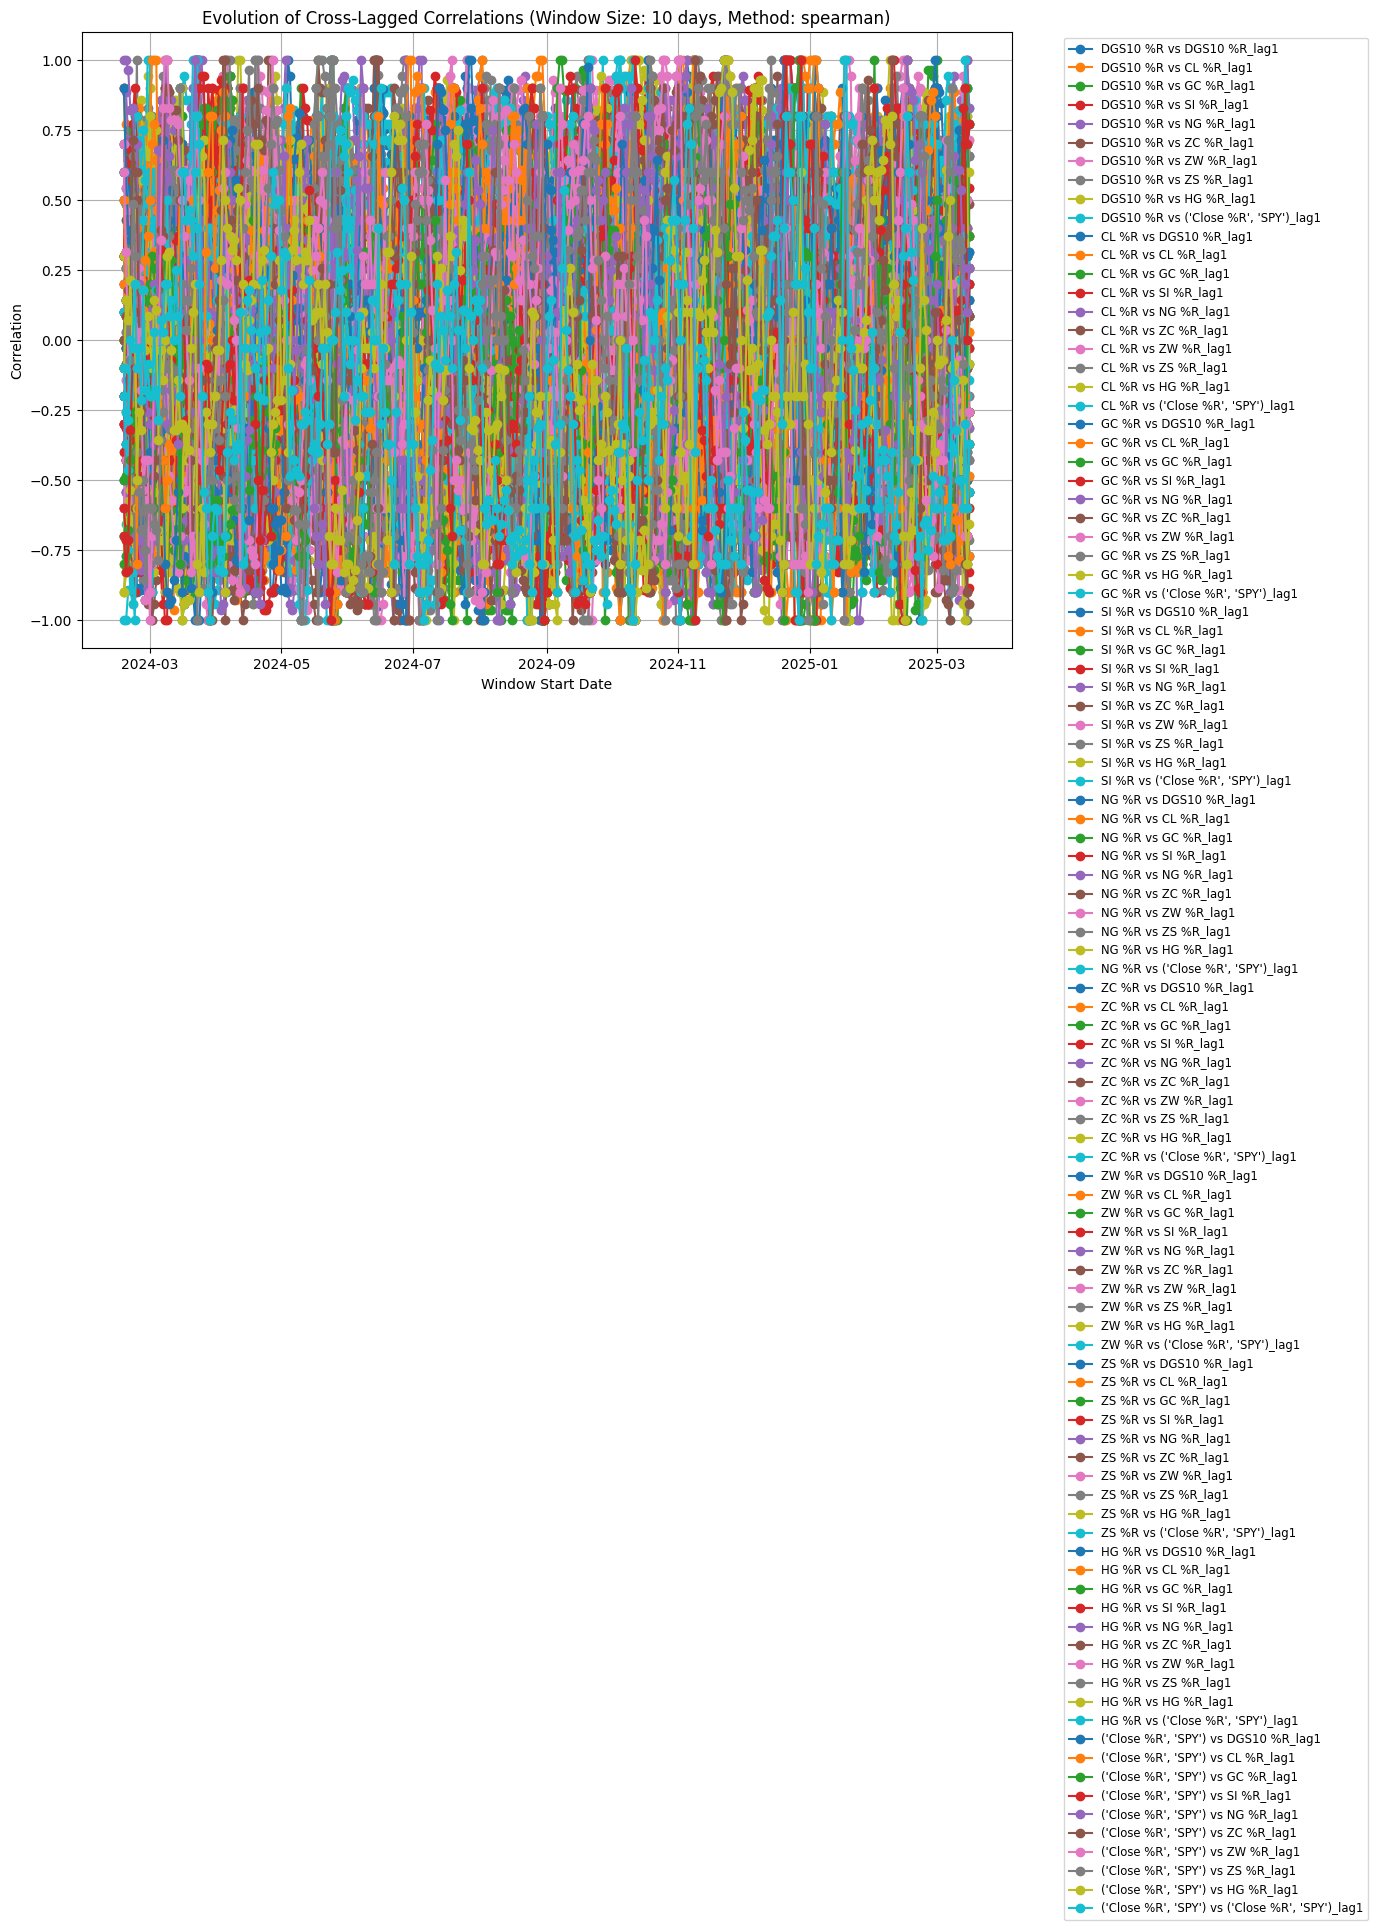

col_t              DGS10 %R                                              \
col_t_minus_1 DGS10 %R_lag1 CL %R_lag1 GC %R_lag1 SI %R_lag1 NG %R_lag1   
window_start                                                              
2024-02-18             -0.3       -0.2        0.1       -0.6        0.1   
2024-02-19        -0.371429  -0.428571   0.142857  -0.542857   0.257143   
2024-02-20        -0.214286  -0.464286   0.142857  -0.571429   0.107143   
2024-02-21              0.0  -0.142857      -0.25       -0.5   0.142857   
2024-02-22        -0.142857  -0.142857  -0.085714  -0.428571   0.142857   
...                     ...        ...        ...        ...        ...   
2025-03-12        -0.392857  -0.321429  -0.035714  -0.285714   0.178571   
2025-03-13        -0.257143   0.085714   0.142857   0.142857  -0.314286   
2025-03-14              0.3        0.9       -0.5       -0.5       -0.5   
2025-03-15              0.5        0.3       -0.9       -0.7       -0.3   
2025-03-16         0.085714        0.2       -0.6  -0.828571       -0.2   

col_t                                                      \
col_t_minus_1 ZC %R_lag1 ZW %R_lag1 ZS %R_lag1 HG %R_lag1   
window_start                                                
2024-02-18           0.6        0.7        0.7        0.0   
2024-02-19      0.485714   0.428571   0.542857  -0.085714   
2024-02-20      0.285714   0.392857   0.464286  -0.142857   
2024-02-21      0.107143  -0.178571   0.142857      -0.75   
2024-02-22      0.371429  -0.257143   0.428571  -0.942857   
...                  ...        ...        ...        ...   
2025-03-12      0.321429   0.142857   0.571429  -0.392857   
2025-03-13      0.142857  -0.028571   0.314286  -0.028571   
2025-03-14           0.0       -0.4        0.2       -0.5   
2025-03-15          -0.3        0.0       -0.3       -0.6   
2025-03-16     -0.028571   0.314286       -0.2  -0.085714   

col_t                                   ... ('Close %R', 'SPY')             \
col_t_minus_1 ('Close %R', 'SPY')_lag1  ...       DGS10 %R_lag1 CL %R_lag1   
window_start                            ...                                  
2024-02-18                        -1.0  ...                 0.9        0.5   
2024-02-19                        -1.0  ...                 0.6   0.142857   
2024-02-20                   -0.892857  ...            0.392857   0.071429   
2024-02-21                   -0.892857  ...            0.357143  -0.071429   
2024-02-22                   -0.942857  ...           -0.028571  -0.028571   
...                                ...  ...                 ...        ...   
2025-03-12                   -0.178571  ...                -0.5  -0.714286   
2025-03-13                        -0.2  ...           -0.428571  -0.542857   
2025-03-14                         0.4  ...                 0.0       -0.2   
2025-03-15                         0.2  ...                 0.3       -0.6   
2025-03-16                   -0.028571  ...            0.314286  -0.485714   

col_t                                                                 \
col_t_minus_1 GC %R_lag1 SI %R_lag1 NG %R_lag1 ZC %R_lag1 ZW %R_lag1   
window_start                                                           
2024-02-18          -0.8       -0.7        1.0        0.0        0.6   
2024-02-19     -0.771429  -0.828571        1.0   0.085714   0.314286   
2024-02-20     -0.678571  -0.714286   0.964286   0.178571  -0.071429   
2024-02-21     -0.428571  -0.321429   0.821429   0.071429   0.071429   
2024-02-22     -0.257143  -0.085714   0.828571   0.714286   0.028571   
...                  ...        ...        ...        ...        ...   
2025-03-12      0.535714   0.142857   0.535714  -0.071429  -0.071429   
2025-03-13      0.828571   0.828571   0.257143  -0.485714  -0.257143   
2025-03-14           0.7        0.7        0.2       -0.8       -0.7   
2025-03-15          -0.3        0.0        0.1       -0.9       -0.3   
2025-03-16     -0.371429        0.2   0.257143  -0.942857  -0.257

In [269]:
plot_correlation_evolution(corr_data, window_size=10, start='2024-02-18', end='2025-03-25', filter_threshold=0.5)